# References:
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 <br>
https://towardsdatascience.com/digit-recognizer-introduction-to-kaggle-competitions-with-image-classification-task-0-995-268fa2b90e13 <br>
https://medium.com/@himanshubeniwal/handwritten-digit-recognition-using-machine-learning-ad30562a9b64 <br>
https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/ <br>
https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj <br>


# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import itertools

from keras.utils.np_utils import to_categorical #convert to one-hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style = 'white', context = 'notebook', palette = 'deep')

Using TensorFlow backend.


# Importing the dataset

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
y_train = train_set['label']
#x_train = train_set.iloc[:, :-1].values
x_train = train_set.drop(labels = ['label'], axis = 1)
del train_set

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

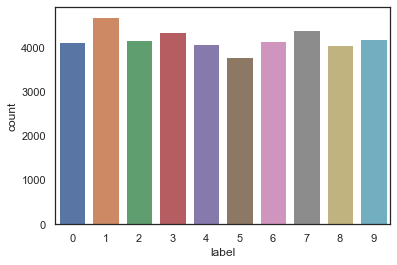

In [3]:
y_count = sns.countplot(y_train)
y_train.value_counts()

# Missing values

In [4]:
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test_set.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

# Normalization
Convert image into grayscale to reduce the effect of illumination difference

In [6]:
x_train = x_train / 255
test_set = test_set / 255

# Reshaping image into 3 dimensions

In [7]:
#We will input height as 28px, width as 28px and number of channels as 1 since the image is grayscaled
x_train = x_train.values.reshape(-1, 28, 28, 1)
test_set = test_set.values.reshape(-1, 28, 28, 1)

# Label Encoding
The test set output is in digits from 0 to 9. We want them to be in binary (0s and 1s). So we need to perform OneHotEncoder on them. For example, 7 will be represented as : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

In [8]:
y_train = to_categorical(y_train, num_classes = 10)

# Splitting our dataset into training set and validation set

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# Visualizing the data

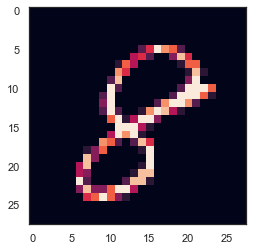

In [10]:
image = plt.imshow(x_train[0][:, :, 0])

# Convolutional Neural Networks using Keras Sequential API
Add one layer at a time, starting from input
### First layer: Convolutional Layer (Conv2D):
Set of learnable filters, each filter transforms a part of the image using kernel filter. Filters are basically a transformation of the image. Used for isolation of features in the image
### Second Layer: Pool Layer (MaxPool2D):
Acts as a downsampling filter. Looks at the 2 neighbouring pixels and picks the maximal value. It's used to decrease the computational cost and, to some extent, reduce overfitting. 
### Dropout:
It is a regularization method where a proportion of nodes in the layer are randomly ignored(weights are set to 0) for each training sample. This forces the network to learn the features in a distributed way.
### Activation Function (ReLU):
Here we will be using the Rectifier Linear Unit activation function. It adds non linearity to the network. 
### Flatten:
Flatten layer converts the final feature maps into a single 1D vector. This is needed so that fully connected layers can be used after convolutional and maxpool layers. 
### Dense:
Artifical Neural Networks Classifier. 

In [11]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Setting score function, loss function and optimization algorithm
### Loss function:
Measures how poorly our model performs on images with known labels. It is the error rate between the observed labels and the predicted ones. 
### Optimizer:
Iteratively improves parameters (filter kernel values, weights and bias of neurons etc) in order to minimize loss

In [12]:
optimizer = RMSprop(epsilon = 1e-08)

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

In order to make the optimizer converge faster and closest to global minimum of the loss function, an annealing method of the Learning Rate (LR) is used. 
It is the step by which the optimizer walks through the "loss landscape". The higher the LR, the bigger the steps and the quicker the convergence. However the sampling is very poor with a high LR and the optimizer could fall into a local minima. 
Therefore a decreasing learning rate (every x steps or epochs) is preferred to efficiently reach the global minimum of the loss function. 

In [13]:
#If the accuracy is not improved after 3 epochs, reduce the LR by half
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [14]:
epochs = 30
batch_size = 86

# Data Augmentation
We need to prevent overfitting in our model. This is done by making the existing dataset even larger by altering the dataset with some transformations to reproduce the variations occuring when a digit is being written (Ex: the number is not centered, numbers are written with different sizes, image is rotated) <br>
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.<br><br>
We will:
Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [16]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
 - 28s - loss: 0.4173 - acc: 0.8647 - val_loss: 0.0642 - val_acc: 0.9795
Epoch 2/30
 - 21s - loss: 0.1354 - acc: 0.9594 - val_loss: 0.0420 - val_acc: 0.9867
Epoch 3/30
 - 21s - loss: 0.0992 - acc: 0.9698 - val_loss: 0.0427 - val_acc: 0.9871
Epoch 4/30
 - 25s - loss: 0.0841 - acc: 0.9745 - val_loss: 0.0298 - val_acc: 0.9898
Epoch 5/30
 - 22s - loss: 0.0755 - acc: 0.9773 - val_loss: 0.0275 - val_acc: 0.9919
Epoch 6/30
 - 22s - loss: 0.0665 - acc: 0.9802 - val_loss: 0.0250 - val_acc: 0.9926
Epoch 7/30
 - 22s - loss: 0.0611 - acc: 0.9820 - val_loss: 0.0316 - val_acc: 0.9905
Epoch 8/30
 - 22s - loss: 0.0541 - acc: 0.9828 - val_loss: 0.0265 - val_acc: 0.9921
Epoch 9/30
 - 23s - loss: 0.0548 - acc: 0.9839 - val_loss: 0.0270 - val_acc: 0.9917

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/30
 - 24s - loss: 0.0433 - acc: 0.9874 - val_loss: 0.0200 - 

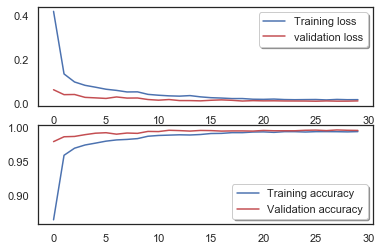

In [17]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Confusion Matrix

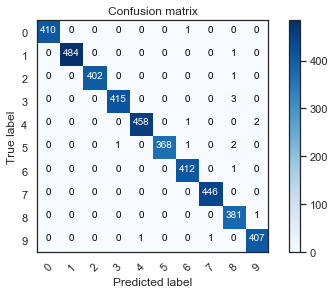

In [18]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    '''Prints and plots confusion matrix. Normalize can be applied by setting normalize = True'''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

# Investigating the errors

In [19]:
errors = (y_pred_classes - y_true != 0)
y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_val[errors]

def display_errors (errors_index, img_errors, pred_errors, obs_errors):
    '''Shows 6 images with their predicted and actual labels'''
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
    for row in range(nrows):
        for col in range(ncols):
            errors = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
    #Probability of the wrong predicted numbers
    y_pred_errors_prob = np.max(y_pred_errors, axis = 1)
    
    #Predicted probability of the true values in the error set
    true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis = 1))
    
    #Difference between probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - true_prob_errors
    
    # Sorted list of the delta prob errors
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    
    # Top 6 errors 
    most_important_errors = sorted_dela_errors[-6:]
    
    # Show the top 6 errors
    display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

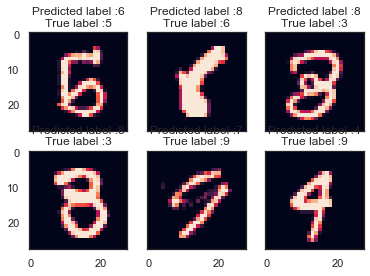

In [20]:

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

In [21]:
results = model.predict(test_set)


In [22]:
results

array([[5.62470177e-17, 4.86046365e-17, 1.00000000e+00, ...,
        3.06240823e-15, 2.53531869e-14, 4.85418204e-17],
       [1.00000000e+00, 3.39588635e-11, 4.58918875e-10, ...,
        3.08255461e-12, 6.05139228e-09, 5.20980503e-09],
       [1.03417947e-12, 7.78852746e-11, 1.75276738e-09, ...,
        2.49700260e-09, 2.79938149e-07, 9.99999404e-01],
       ...,
       [5.50078843e-22, 2.80532473e-18, 2.07469963e-15, ...,
        4.18891250e-16, 1.44614477e-13, 1.19375691e-14],
       [1.96251837e-09, 6.40492326e-09, 2.93611642e-08, ...,
        2.88565207e-06, 2.78660632e-08, 9.99992967e-01],
       [1.43394671e-17, 1.03576066e-17, 1.00000000e+00, ...,
        3.99297366e-16, 3.42841879e-12, 4.08130702e-16]], dtype=float32)

In [23]:
results = np.argmax(results,axis = 1)

In [24]:
results

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [25]:
results = pd.Series(results,name="Label")
results

0        2
1        0
2        9
3        0
4        3
5        7
6        0
7        3
8        0
9        3
10       5
11       7
12       4
13       0
14       4
15       3
16       3
17       1
18       9
19       0
20       9
21       1
22       1
23       5
24       7
25       4
26       2
27       7
28       4
29       7
        ..
27970    5
27971    0
27972    4
27973    8
27974    0
27975    3
27976    6
27977    0
27978    1
27979    9
27980    3
27981    1
27982    1
27983    0
27984    4
27985    5
27986    2
27987    2
27988    9
27989    6
27990    7
27991    6
27992    1
27993    9
27994    7
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [26]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

In [27]:
submission.to_csv("prediction.csv",index=False)